This code runs Deep Learning on nutau and nue samples created by Dasha. 

This code runs in a python 3.7 conda environment constructed as follows:
- conda create --name tf-gpu tensorflow-gpu keras scikit-learn matplotlib ipykernel nb_conda_kernels [Pillow]
- conda activate tf-gpu
(Pillow is for image manipulation for making heat maps, but I haven't got it to work yet.  Can remove from environment.)

To run with multiple GPUs on CyberLAMP you must specify the "nodes" and "gpus" qualifiers in the same chunk.  For example:
- qsub -I -A cyberlamp -l qos=cl_higpu -l nodes=1:ppn=1:gpus=4:shared -l mem=24gb -l walltime=4:00:00

In [78]:
import os

# Set which GPU to use.  This probably needs to be done before any other CUDA vars get defined.
# Use the command "nvidia-smi" to get association of a particular GPU with a particular number.
os.environ["CUDA_DEVICE_ORDER"] = "PCI_BUS_ID"
os.environ["CUDA_VISIBLE_DEVICES"]= "0,2"

In [79]:
from __future__ import division
import matplotlib as mpl
import matplotlib.pyplot as plt
import numpy as np
import pickle
from sklearn.utils import shuffle
from sklearn.metrics import classification_report, confusion_matrix
from keras import layers
from keras import models
import json


In [80]:
c =0.299792458
n =1.3195
v=c/n 
print(v)

0.2272015596816976


In [81]:
nu_size = 7737578
nu_data = np.memmap('/fastio2/dasha/double_pulse/nu_data.npy', mode = 'r', dtype ='float32', shape = (nu_size,300,60))

In [82]:
print(np.amax(nu_data))
print(np.amin(nu_data))

7.63065e-09
-4.75539e-10


In [83]:
nu_info = np.memmap('/fastio2/dasha/double_pulse/nu_info.npy', mode = 'r', dtype ='float32', shape = (nu_size,3))
print(nu_info[0])

[23616.275  3619.7    1132.7  ]


In [84]:
nu_labels = np.memmap('/fastio2/dasha/double_pulse/nu_label.npy', mode = 'r', dtype ='float32', shape = (nu_size))
labels = []
for i in nu_labels:
    if i == 4:
        labels.append([0,1])
    elif i == 0:
        labels.append([1,0])
    else:
        labels.append([0,0])
labels = np.array(labels)
print(labels.shape)
print(labels[0:10])

(7737578, 2)
[[1 0]
 [1 0]
 [1 0]
 [1 0]
 [1 0]
 [1 0]
 [1 0]
 [1 0]
 [1 0]
 [1 0]]


In [85]:
print(labels[4400000:4400010])

[[0 0]
 [0 0]
 [0 0]
 [0 0]
 [0 0]
 [0 0]
 [0 0]
 [0 0]
 [0 0]
 [0 0]]


In [86]:
print(sum(labels))

[2885285  909096]


In [87]:
idx = np.arange(nu_size)

In [88]:
no_mu_cc_idx = []
for i in idx:
    if (sum(labels[i]) != 0) and (nu_info[i][0] >500000) and (nu_info[i][0] <1500000):
        no_mu_cc_idx.append(i)
idx = np.array(no_mu_cc_idx)
print(len(idx))

373236


In [89]:
# limit_S = 218972/2
# limit_D = 218972/2
# no_mu_cc_idx = []
# count = 0

# for i in idx:
#     if (labels[i][1] == 1) and (nu_info[i][0] >500000) and (nu_info[i][0] <1500000):
#         count = count +1
#         if count < limit_D:
#             no_mu_cc_idx.append(i)

# count = 0
# for i in idx:
#     if (labels[i][0] == 1) and (nu_info[i][0] >500000) and (nu_info[i][0] <1500000):
#         count = count +1
#         if count < limit_S:
#             no_mu_cc_idx.append(i)

# idx = np.array(no_mu_cc_idx)
# print(len(idx))

In [90]:
np.random.shuffle(idx)

In [91]:
train_idx = idx[:250000] 
test_idx = idx[250000:300000] 
valid_idx = idx[300000:]

In [92]:
train_data = []
train_labels = []
test_data = []
test_labels = []
valid_data = []
valid_labels = []

for i in train_idx:
    train_data.append(nu_data[i])
    train_labels.append(labels[i])
for i in test_idx:
    test_data.append(nu_data[i])
    test_labels.append(labels[i])
for i in valid_idx:
    valid_data.append(nu_data[i])
    valid_labels.append(labels[i])

train_data = np.array(train_data)
train_labels = np.array(train_labels)
test_data = np.array(test_data)
test_labels = np.array(test_labels)
valid_data = np.array(valid_data)
valid_labels = np.array(valid_labels)
    

In [93]:
print(train_data.shape, train_labels.shape)
print(test_data.shape, test_labels.shape)
print(valid_data.shape, valid_labels.shape)

(250000, 300, 60) (250000, 2)
(50000, 300, 60) (50000, 2)
(73236, 300, 60) (73236, 2)


In [94]:
print(sum(train_labels))
print(sum(test_labels))
print(sum(valid_labels))

[176765  73235]
[35218 14782]
[51766 21470]


In [95]:
train_data = train_data.reshape((len(train_data),300,60,1))
train_data = train_data.astype('float32')/10**-8
mean = np.mean(train_data)
std = np.std(train_data)
print(mean,std)
train_data = train_data - mean
train_data = train_data/std

valid_data = valid_data.reshape((len(valid_data),300,60,1))
valid_data = valid_data.astype('float32')/10**-8
valid_data = valid_data - mean
valid_data = valid_data/std

test_data = test_data.reshape((len(test_data),300,60,1))
test_data = test_data.astype('float32')/10**-8
test_data = test_data - mean
test_data = test_data/std

0.0013215205 0.015272634


In [96]:
print(np.amax(train_data))
print(np.amin(train_data))

45.551655
-0.85231423


In [62]:
#from keras.models import load_model
#model = load_model('/data/dfc13/DoublePulse/Models/DP_model_11c.h5')
#model = load_model('/data/dfc13/DoublePulse/Models/DP_model_11c_noNC_NoNumu_65.h5')
#model.summary()
#with open("/data/dfc13/DoublePulse/Models/DP_model_11c_noNC_NoNumu_65.json", 'r') as f:
#    history = json.load(f)
#print(len(history['val_loss']))

In [63]:
# model = models.Sequential()
# model.add(layers.Conv2D(32, (3, 3), activation='relu', input_shape=(300, 60, 1)))
# model.add(layers.MaxPooling2D((2, 2)))
# model.add(layers.Conv2D(64, (3, 3), activation='relu'))
# model.add(layers.MaxPooling2D((2, 2)))
# model.add(layers.Conv2D(128, (3, 3), activation='relu'))
# model.add(layers.MaxPooling2D((2, 2)))
# model.add(layers.Conv2D(128, (3, 3), activation='relu'))
# model.add(layers.MaxPooling2D((2, 2)))
# model.add(layers.Flatten())
# model.add(layers.Dropout(0.5))
# model.add(layers.Dense(512, activation='relu'))
# model.add(layers.Dense(64, activation='relu'))
# model.add(layers.Dense(2, activation='softmax'))
# model.summary()
# from keras import optimizers
# import tensorflow as tf

# run_opts = tf.RunOptions(report_tensor_allocations_upon_oom = True)

# sgd = optimizers.SGD(lr=0.01)
# model.compile(loss='categorical_crossentropy',
#               optimizer=sgd,
#               metrics=['accuracy'])
# #              options = run_opts)
#history = model.fit(train_data,train_labels, epochs=60, validation_data=(valid_data,valid_labels), batch_size =256)

In [64]:
#model = models.Sequential()
#model.add(layers.Conv2D(32, (3, 3), activation='relu', input_shape=(300, 60, 1)))
#model.add(layers.MaxPooling2D((2, 2)))
#model.add(layers.Conv2D(64, (3, 3), activation='relu'))
#model.add(layers.MaxPooling2D((2, 2)))
#model.add(layers.Conv2D(64, (3, 3), activation='relu'))
#model.add(layers.MaxPooling2D((2, 2)))
#model.add(layers.Flatten())
#model.add(layers.Dense(64, activation='relu'))
#model.add(layers.Dense(2, activation='softmax'))
#model.summary()

In [97]:
from keras.utils import multi_gpu_model
from keras import optimizers
import tensorflow as tf

with tf.device('/cpu:0'):
    model = models.Sequential()
    model.add(layers.Conv2D(32, (15, 3), activation='relu', input_shape=(300, 60, 1)))
    model.add(layers.MaxPooling2D((2, 2)))
    model.add(layers.Conv2D(64, (15, 3), activation='relu'))
    model.add(layers.MaxPooling2D((2, 2)))
    model.add(layers.Conv2D(32, (15, 3), activation='relu'))
    model.add(layers.MaxPooling2D((2, 2)))
    model.add(layers.Flatten())
    model.add(layers.Dropout(0.5))
    model.add(layers.Dense(128, activation='relu'))
    model.add(layers.Dense(64, activation='relu'))
    model.add(layers.Dense(2, activation='softmax'))
    model.summary()
    
parallel_model = multi_gpu_model(model,gpus=2)
sgd = optimizers.SGD(lr=0.01)
parallel_model.compile(loss='categorical_crossentropy',
              optimizer=sgd,
              metrics=['accuracy'])
history = parallel_model.fit(train_data,train_labels, epochs=200, validation_data=(valid_data,valid_labels), batch_size =256)

_________________________________________________________________
Layer (type)                 Output Shape              Param #   
conv2d_20 (Conv2D)           (None, 286, 58, 32)       1472      
_________________________________________________________________
max_pooling2d_20 (MaxPooling (None, 143, 29, 32)       0         
_________________________________________________________________
conv2d_21 (Conv2D)           (None, 129, 27, 64)       92224     
_________________________________________________________________
max_pooling2d_21 (MaxPooling (None, 64, 13, 64)        0         
_________________________________________________________________
conv2d_22 (Conv2D)           (None, 50, 11, 32)        92192     
_________________________________________________________________
max_pooling2d_22 (MaxPooling (None, 25, 5, 32)         0         
_________________________________________________________________
flatten_7 (Flatten)          (None, 4000)              0         
__________

In [32]:
history = parallel_model.fit(train_data,train_labels, epochs=60, validation_data=(valid_data,valid_labels), batch_size =256)

NameError: name 'parallel_model' is not defined

In [ ]:
print(len(test_data))

In [98]:
history_dict = history.history # Get the dictionary containing each metric and the loss for each epoch
json.dump(history_dict, open('/data/dfc13/DoublePulse/Models/DP_model_13_noNC_NoNumu_20.json', 'w')) # Save it under the form of a json file
#
model.save('/data/dfc13/DoublePulse/Models/DP_model_13_noNC_NoNumu_200.h5') # Save the model
#
#ResultsFile = open('/data/dfc13/DoublePulse/Models/DP_model_11c_noNC_NoNumu_125.txt','w') # File for saving the results of the fit.
#
# 8: multiple conv2d layers a la textbook (32 (3,3) then 64, 128, 128, dropout 0.3, dense 256(relu), 64(relu), 2(softmax)
# 8b: same as 8 but with 50 trials
# 8b[not c didn't update the line above]: same as 8b but with dropout 0.5.
# 8c: changed SGC "lr" from 0.01->0.001.  This smoothed things out a lot.  Sort of.  But had 0% accuracy for nutaus.
# 8d: changed SGC "lr" from 0.001->0.005.
# 8e: decreased size of training set to 24k, increased size of validation set to 4k (24k:28k) and increased test set (28k:)
# 8f: changed SGC "lr" from 0.005->0.01.  200 epochs. 97%/37%.
# 8g: lr=0.02, 50 epochs: 98%/29%.

# 9a: changed dense 256 -> 512.  50 epochs. 100%/22%
# 9b: same as above, 200 epochs. 97%/39%.
# 9c: same as above, lr = 0.01.  200 epochs. 97%/36%.
# 9d: same as above, 500 epochs batch_size = 64. 96%/40%.
# 10a: Testing selection of particular GPU.  20 epochs, batch_size = 128.
# 10b: Testing parallelization.  50 epochs, batch_size = 128, one GPU. 98%/22%.
# 10g: 
# New_1: New data (160000 ims)
# New_2_Qt5000: Qst >5000, Qtot >10000
# New_3_Qt5000: No numu, Qst >5000, Qtot >10000
# New_4_Qt5000: No numu, Qst >5000, Qtot >10000, 2 layer
# New_4_EnCut: No num. new data, 0.5to1.5PeV En
# New_4_EnCut_NoNC: No num. new data, 0.5to1.5PeV En, No NC events
# New_4_EnCut_NC_Equal: No num. new data, 0.5to1.5PeV En
# 4_New_Equal_NC_NoNumu - for ratio study

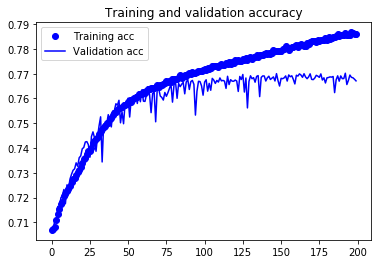

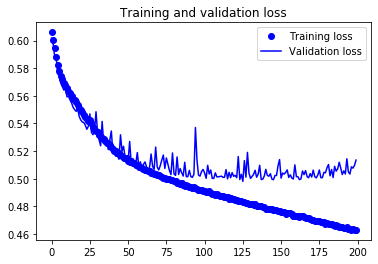

In [99]:
acc = history.history['acc']
val_acc = history.history['val_acc']
loss = history.history['loss']
val_loss = history.history['val_loss']

epochs = range(len(acc))

plt.plot(epochs, acc, 'bo', label='Training acc')
plt.plot(epochs, val_acc, 'b', label='Validation acc')
plt.title('Training and validation accuracy')
plt.legend()

plt.figure()

plt.plot(epochs, loss, 'bo', label='Training loss')
plt.plot(epochs, val_loss, 'b', label='Validation loss')
plt.title('Training and validation loss')
plt.legend()

plt.show()

In [37]:
result = model.evaluate(test_data,test_labels)
print(result)

RuntimeError: You must compile a model before training/testing. Use `model.compile(optimizer, loss)`.

In [100]:
test_pred = model.predict(test_data)

In [101]:
print(test_pred[0:100])
print(test_pred.argmax(axis=1)[0:100])

[[7.75276780e-01 2.24723175e-01]
 [7.25968122e-01 2.74031848e-01]
 [8.97878051e-01 1.02121979e-01]
 [7.26083875e-01 2.73916185e-01]
 [7.39847600e-01 2.60152400e-01]
 [7.30428815e-01 2.69571245e-01]
 [8.69801641e-01 1.30198374e-01]
 [9.58053589e-01 4.19463851e-02]
 [8.07627916e-01 1.92372084e-01]
 [6.79946840e-01 3.20053190e-01]
 [7.66625345e-01 2.33374625e-01]
 [7.29880989e-01 2.70119101e-01]
 [8.52865815e-01 1.47134185e-01]
 [8.64434302e-01 1.35565668e-01]
 [7.33405530e-01 2.66594470e-01]
 [9.35797751e-01 6.42023012e-02]
 [7.34971881e-01 2.65028149e-01]
 [8.39039862e-01 1.60960123e-01]
 [7.69815326e-01 2.30184659e-01]
 [8.13864410e-01 1.86135620e-01]
 [7.13456988e-01 2.86543012e-01]
 [9.33927834e-01 6.60721362e-02]
 [8.32181633e-01 1.67818367e-01]
 [4.99906659e-01 5.00093281e-01]
 [8.06712508e-01 1.93287537e-01]
 [9.44172680e-01 5.58273531e-02]
 [8.58562946e-01 1.41437069e-01]
 [5.85190833e-01 4.14809108e-01]
 [7.20391691e-01 2.79608369e-01]
 [9.65277851e-01 3.47221494e-02]
 [7.658017

In [102]:
matrix = confusion_matrix(test_labels.argmax(axis=1), test_pred.argmax(axis=1))
report = classification_report(test_labels.argmax(axis=1), test_pred.argmax(axis=1))

In [103]:
#print("True Positive",tp)
#print("True Negative",tn)
#print("False Positive",fp)
#print("False Negative",fn)
print(matrix)
print(report)

#ResultsFile.write(repr(matrix))
#ResultsFile.write('\n')
#ResultsFile.write(report)
#ResultsFile.close()

[[34370   848]
 [10930  3852]]
              precision    recall  f1-score   support

           0       0.76      0.98      0.85     35218
           1       0.82      0.26      0.40     14782

    accuracy                           0.76     50000
   macro avg       0.79      0.62      0.62     50000
weighted avg       0.78      0.76      0.72     50000



/home/dup193/anaconda3/envs/tf-gpu/lib/python3.7/site-packages/ipykernel_launcher.py:4: RuntimeWarning: More than 20 figures have been opened. Figures created through the pyplot interface (`matplotlib.pyplot.figure`) are retained until explicitly closed and may consume too much memory. (To control this warning, see the rcParam `figure.max_open_warning`).
  after removing the cwd from sys.path.


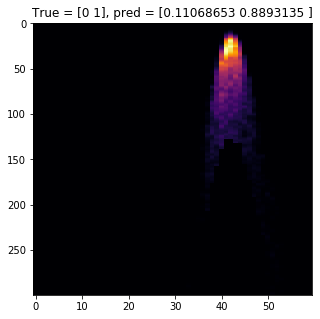

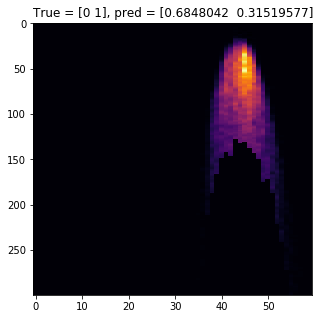

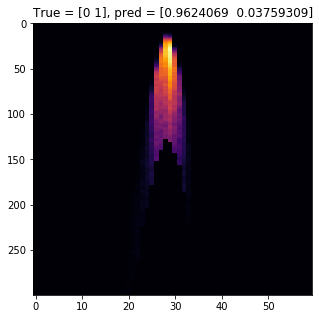

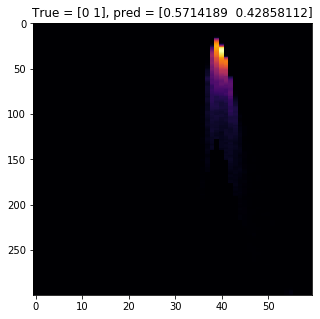

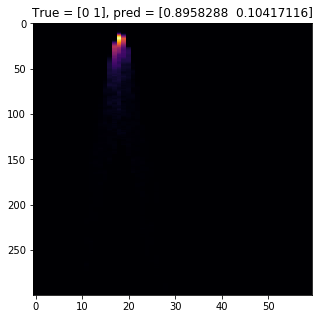

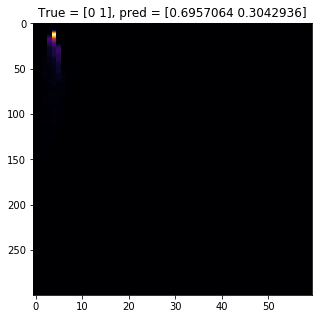

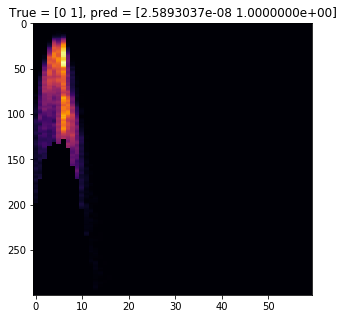

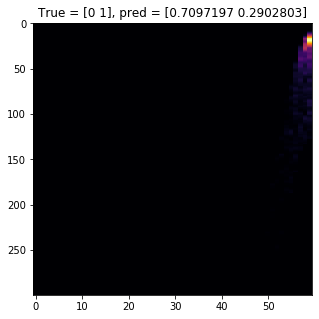

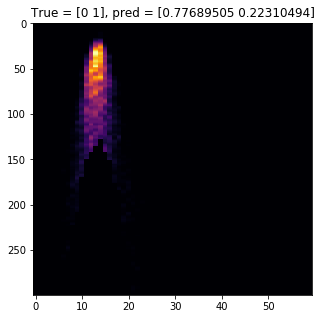

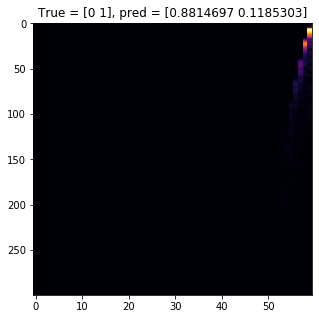

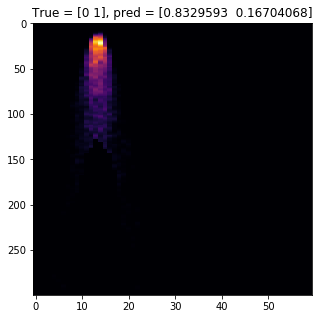

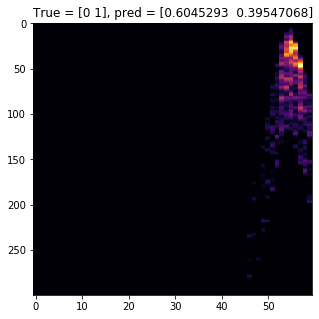

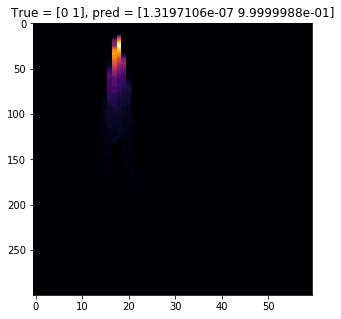

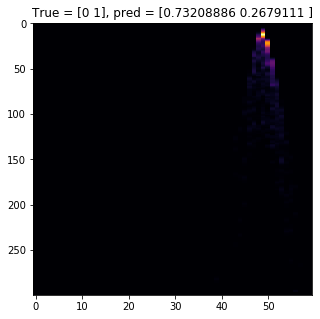

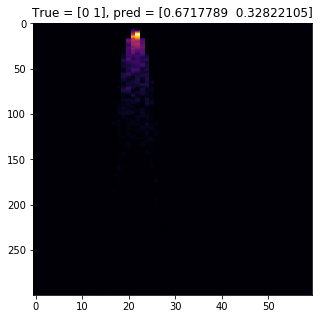

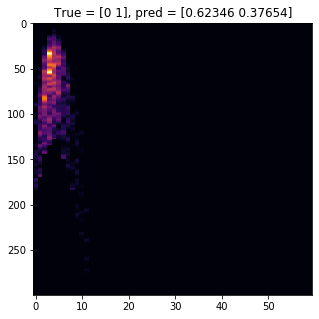

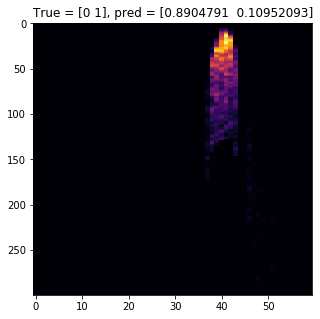

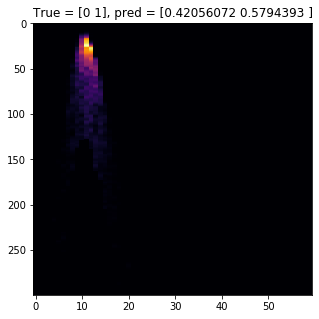

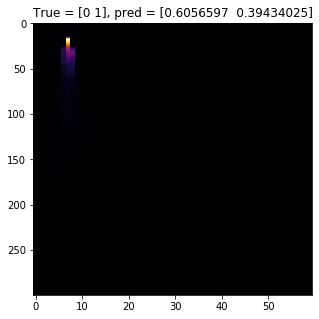

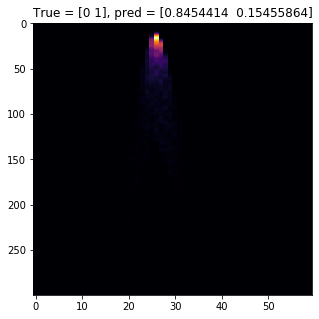

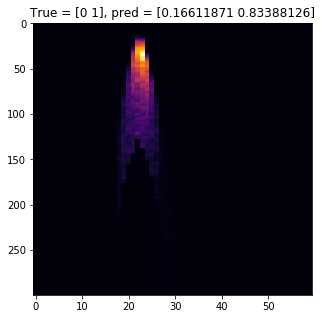

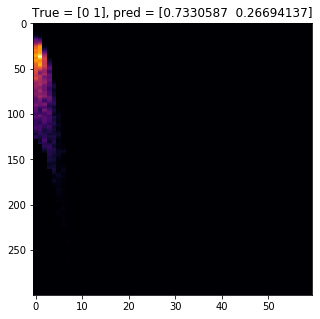

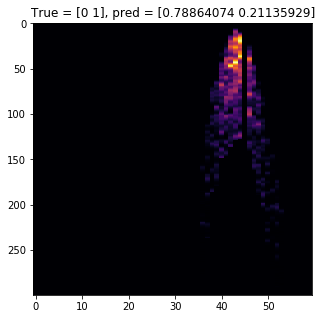

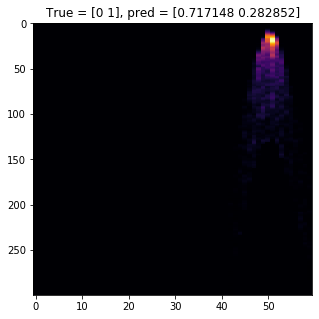

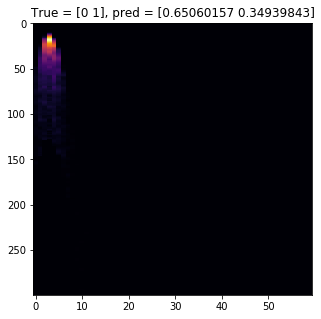

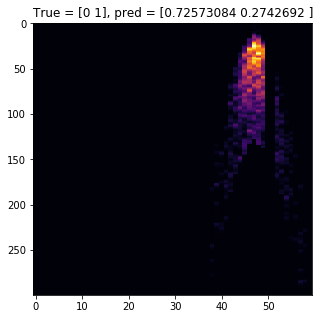

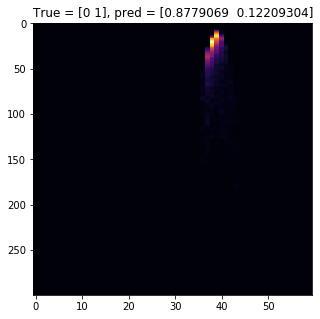

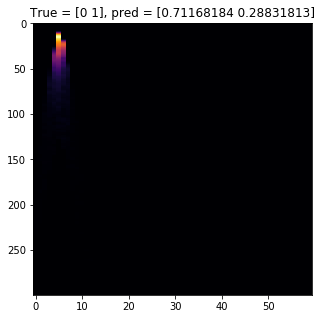

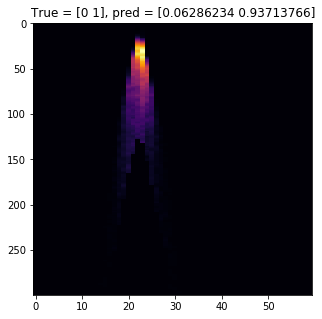

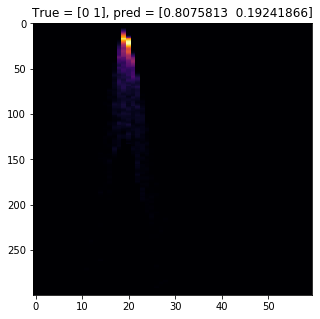

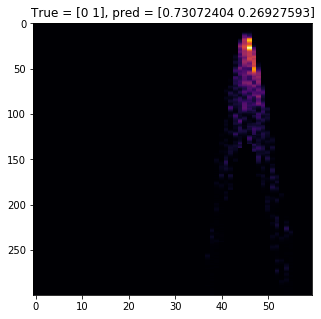

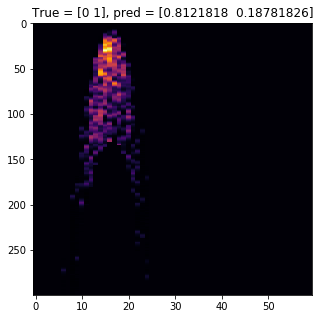

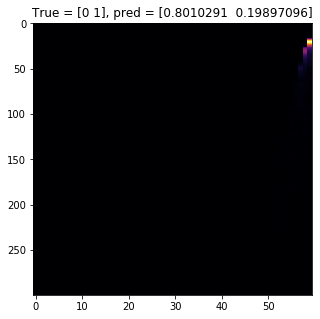

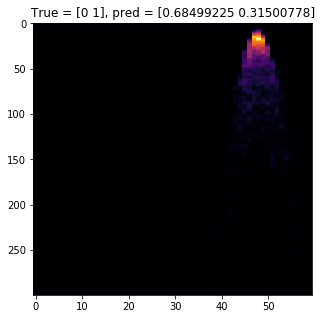

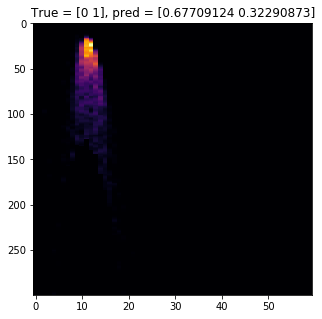

In [42]:
for i, img in enumerate(test_data[:100]):
    if test_labels[i][0] == 0:
        im = img.reshape(300,60)
        fig = plt.figure(figsize=(5, 5))
        ax = fig.add_subplot(111)
        plt.title('True = {0}, pred = {1}'.format(test_labels[i], test_pred[i]))
        ax.imshow(im, interpolation='nearest', aspect='auto', cmap= 'inferno')